## Import

In [1]:
#################################
# # when running google colab # #
#################################
# from google.colab import drive
# drive.mount('/content/gdrive')
# !pip install scikeras --quiet

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import roc_curve, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

N_FEATURES = 31
TIMESTEPS = 1
DATASET_LINK = "dataset/overall.csv"
TEST_DATA_LINK = "dataset/overall_test.csv"

# random seed for reproducibility
SEED = 10

### LOAD DATASET
> * Check for class imbalance

In [3]:
# loading of dataset
df = pd.read_csv(DATASET_LINK)

df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,Andy,1,1,0.142176,0.156880,0.014704,0.127937,0.142299,0.014361,0.155919,...,0.128263,0.085967,-0.042296,0.120442,0.209372,0.088930,0.116911,0.165437,0.048526,0.160258
1,Andy,1,2,0.141793,0.164635,0.022842,0.121625,0.152146,0.030520,0.137039,...,0.144490,0.082397,-0.062093,0.101188,0.126066,0.024878,0.098424,0.130661,0.032238,0.173819
2,Andy,1,3,0.157152,0.147220,-0.009932,0.134796,0.145790,0.010994,0.124892,...,0.135452,0.082423,-0.053029,0.108598,0.155843,0.047244,0.118759,0.146550,0.027791,0.173512
3,Andy,1,4,0.158673,0.142487,-0.016186,0.118908,0.159179,0.040271,0.133175,...,0.114266,0.072556,-0.041711,0.101937,0.145692,0.043755,0.096300,0.122580,0.026280,0.190808
4,Andy,1,5,0.166583,0.157102,-0.009480,0.115094,0.141103,0.026009,0.135121,...,0.125474,0.089247,-0.036227,0.114211,0.149136,0.034925,0.121197,0.230113,0.108917,0.143299


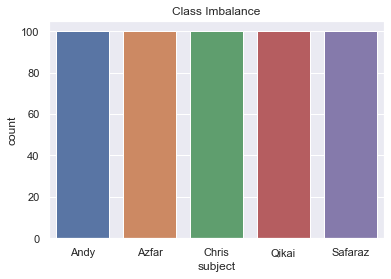

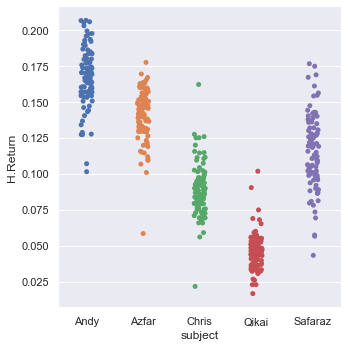

In [4]:
#################################
# # check for class imbalance # #
#################################

sns.set_theme(style="darkgrid")
ax = sns.countplot(x="subject", data=df).set_title("Class Imbalance")

# remove missing values if available
df = df.dropna()

sns.catplot(x="subject", y="H.Return", data=df)

### PREPARING DATASET
> * Split data into X and Y 
> * Convert Y into one-hot-encoding

In [5]:
dataset = df.values

# divide data into features X and target (classes) Y
X = dataset[:,3:].astype(float)
Y = dataset[:,0]

# convert target Y to labelbinarizer Y for model
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

#################################
# # get all the encoded class # #
#################################
print("LabelBinarizer is able to decipher: ")
print(lb.classes_)
print("\n")

###########################
# # print X and Y shape # #
###########################
print("X dataset shape: " + str(X.shape))
print("Y dataset shape: " + str(Y.shape))

LabelBinarizer is able to decipher: 
['Andy' 'Azfar' 'Chris' 'Qikai' 'Safaraz']


X dataset shape: (500, 31)
Y dataset shape: (500, 5)


### SPLITTING DATASET
> * Split data into train and test dataset 
> * Normalisation performed based on X_train
> * Reshaping of dataset for LSTM Timesteps

In [6]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=SEED)


##############################################
# # normalisation and reshaping of dataset # #
##############################################
# normalisation to 0 to 1
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# reshaping the dataset to include LSTM Timesteps
X_train = np.asarray(X_train, dtype=np.float32)
X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
X_test = np.asarray(X_test, dtype=np.float32)
X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

# retrieve number of classes
n_classes = y_train.shape[1]

print("X train shape: " + str(X_train.shape))
print("Y train shape: " + str(y_train.shape))
print("X test shape: " + str(X_test.shape))
print("Y test shape: " + str(y_test.shape))

X train shape: (400, 1, 31)
Y train shape: (400, 5)
X test shape: (100, 1, 31)
Y test shape: (100, 5)


### CREATE MODEL
> * Create base model
> * Wrap it with KerasClassifier

In [7]:
# create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, 
                 input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # softmax for multi-class classification
    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=200, 
                            batch_size=5)
    return model

### INITIATE KFOLD VALIDATION
> * evaluate best kfold validation
> * generate loss and accuracy graph
> * perform actual kfold validation

##### evaluate suitable folds for kfold validation

> folds=2, accuracy=94.250% (min=92.500%, max=96.000%)
> folds=3, accuracy=95.997% (min=94.737%, max=97.015%)
> folds=4, accuracy=95.750% (min=94.000%, max=97.000%)
> folds=5, accuracy=96.500% (min=95.000%, max=97.500%)
> folds=6, accuracy=94.750% (min=92.424%, max=97.015%)
> folds=7, accuracy=95.506% (min=92.982%, max=100.000%)
> folds=8, accuracy=96.250% (min=94.000%, max=98.000%)
> folds=9, accuracy=96.515% (min=93.333%, max=100.000%)
> folds=10, accuracy=96.500% (min=92.500%, max=100.000%)


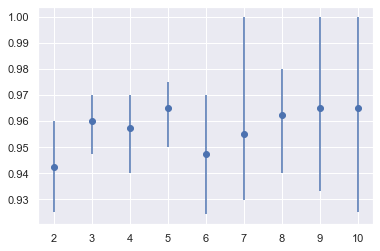

In [8]:
# from sklearn.model_selection import LeaveOneOut
def evaluate_kfold(X_train, y_train, SEED):
    
    # evaluate the model    
    folds = range(2,11)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print('> folds=%d, accuracy=%.3f%% (min=%.3f%%, max=%.3f%%)' %
              (k, k_mean*100, k_min*100, k_max*100))
        
        # store mean accuracy
        means.append(k_mean)
        
        # store min and max relative to the mean
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
evaluate_kfold(X_train, y_train, SEED)

##### generate kfold validation accuracy and loss

Testing accuracy: 97.500%
Testing accuracy: 93.750%
Testing accuracy: 98.750%
Testing accuracy: 93.750%
Testing accuracy: 96.250%
Accuracy: Mean=96.000 Std=2.000, n=5


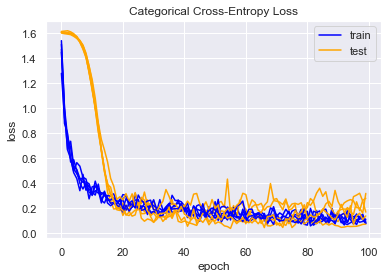

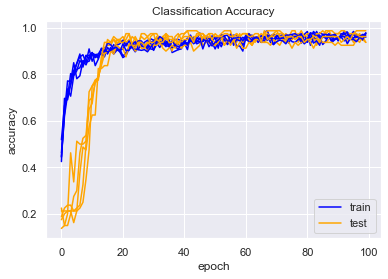

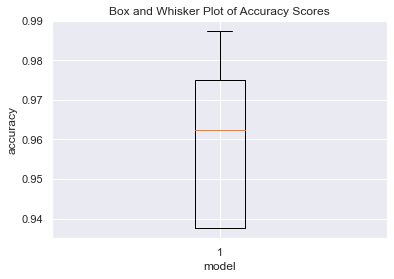

In [9]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=10, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print('Accuracy: Mean=%.3f Std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    plt.show()
    
evaluate_kfold_model(X_train, y_train, SEED)

##### perform actual KFold Validation

In [10]:
# create model
model = create_model()

n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True,
              random_state=SEED)

valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)

Epoch 1/200
64/64 [==============================] - 3s 3ms/step - loss: 1.5149 - accuracy: 0.4031
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 1.1368 - accuracy: 0.5500
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.9693 - accuracy: 0.6375
Epoch 4/200
64/64 [==============================] - 0s 3ms/step - loss: 0.7999 - accuracy: 0.6875
Epoch 5/200
64/64 [==============================] - 0s 3ms/step - loss: 0.7887 - accuracy: 0.6969
Epoch 6/200
64/64 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.7531
Epoch 7/200
64/64 [==============================] - 0s 3ms/step - loss: 0.7766 - accuracy: 0.7281
Epoch 8/200
64/64 [==============================] - 0s 3ms/step - loss: 0.6286 - accuracy: 0.7656
Epoch 9/200
64/64 [==============================] - 0s 3ms/step - loss: 0.5736 - accuracy: 0.7625
Epoch 10/200
64/64 [==============================] - 0s 3ms/step - loss: 0.6597 - accuracy: 0.7500
Epoch 11/

64/64 [==============================] - 0s 3ms/step - loss: 0.2298 - accuracy: 0.8969
Epoch 84/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3778 - accuracy: 0.8969
Epoch 85/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3083 - accuracy: 0.8938
Epoch 86/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2832 - accuracy: 0.8969
Epoch 87/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3678 - accuracy: 0.8844
Epoch 88/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3226 - accuracy: 0.9187
Epoch 89/200
64/64 [==============================] - 0s 2ms/step - loss: 0.2760 - accuracy: 0.9000
Epoch 90/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3121 - accuracy: 0.9219
Epoch 91/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3033 - accuracy: 0.9062
Epoch 92/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2685 - accuracy: 0.9031
Epoch 93/200


64/64 [==============================] - 0s 3ms/step - loss: 0.2371 - accuracy: 0.9375
Epoch 165/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2229 - accuracy: 0.9281
Epoch 166/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1499 - accuracy: 0.9563
Epoch 167/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1545 - accuracy: 0.9375
Epoch 168/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1496 - accuracy: 0.9563
Epoch 169/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2910 - accuracy: 0.9031
Epoch 170/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2029 - accuracy: 0.9344
Epoch 171/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2740 - accuracy: 0.9156
Epoch 172/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2058 - accuracy: 0.9438
Epoch 173/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2426 - accuracy: 0.9281
Epoc

64/64 [==============================] - 0s 3ms/step - loss: 0.3450 - accuracy: 0.8906
Epoch 45/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3178 - accuracy: 0.8875
Epoch 46/200
64/64 [==============================] - 0s 3ms/step - loss: 0.4083 - accuracy: 0.8438
Epoch 47/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3784 - accuracy: 0.8750
Epoch 48/200
64/64 [==============================] - 0s 2ms/step - loss: 0.2928 - accuracy: 0.9125
Epoch 49/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3499 - accuracy: 0.8781
Epoch 50/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3620 - accuracy: 0.8875
Epoch 51/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3633 - accuracy: 0.8875
Epoch 52/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3491 - accuracy: 0.9094
Epoch 53/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3857 - accuracy: 0.8687
Epoch 54/200


64/64 [==============================] - 0s 3ms/step - loss: 0.1862 - accuracy: 0.9594
Epoch 126/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1510 - accuracy: 0.9375
Epoch 127/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2171 - accuracy: 0.9250
Epoch 128/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2466 - accuracy: 0.9187
Epoch 129/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1919 - accuracy: 0.9281
Epoch 130/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2547 - accuracy: 0.9156
Epoch 131/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3133 - accuracy: 0.9125
Epoch 132/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1524 - accuracy: 0.9438
Epoch 133/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1852 - accuracy: 0.9375
Epoch 134/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1551 - accuracy: 0.9469
Epoc

64/64 [==============================] - 0s 3ms/step - loss: 0.7181 - accuracy: 0.7375
Epoch 6/200
64/64 [==============================] - 0s 3ms/step - loss: 0.7595 - accuracy: 0.7156
Epoch 7/200
64/64 [==============================] - 0s 3ms/step - loss: 0.6210 - accuracy: 0.7750
Epoch 8/200
64/64 [==============================] - 0s 3ms/step - loss: 0.5829 - accuracy: 0.7875
Epoch 9/200
64/64 [==============================] - 0s 3ms/step - loss: 0.6065 - accuracy: 0.7750
Epoch 10/200
64/64 [==============================] - 0s 3ms/step - loss: 0.5190 - accuracy: 0.8156
Epoch 11/200
64/64 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.7656
Epoch 12/200
64/64 [==============================] - 0s 3ms/step - loss: 0.5206 - accuracy: 0.8094
Epoch 13/200
64/64 [==============================] - 0s 3ms/step - loss: 0.4943 - accuracy: 0.8188
Epoch 14/200
64/64 [==============================] - 0s 3ms/step - loss: 0.4880 - accuracy: 0.8438
Epoch 15/200
64/6

64/64 [==============================] - 0s 3ms/step - loss: 0.2906 - accuracy: 0.8969
Epoch 88/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2233 - accuracy: 0.9156
Epoch 89/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2254 - accuracy: 0.9187
Epoch 90/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1794 - accuracy: 0.9500
Epoch 91/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1985 - accuracy: 0.9312
Epoch 92/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3347 - accuracy: 0.9000
Epoch 93/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3057 - accuracy: 0.8906
Epoch 94/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2663 - accuracy: 0.9094
Epoch 95/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2275 - accuracy: 0.9250
Epoch 96/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2198 - accuracy: 0.9312
Epoch 97/200


64/64 [==============================] - 0s 3ms/step - loss: 0.2153 - accuracy: 0.9250
Epoch 169/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2041 - accuracy: 0.9438
Epoch 170/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1104 - accuracy: 0.9719
Epoch 171/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2086 - accuracy: 0.9281
Epoch 172/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2199 - accuracy: 0.9375
Epoch 173/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1965 - accuracy: 0.9406
Epoch 174/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1048 - accuracy: 0.9594
Epoch 175/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1809 - accuracy: 0.9406
Epoch 176/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1124 - accuracy: 0.9688
Epoch 177/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2607 - accuracy: 0.9344
Epoc

Epoch 49/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3708 - accuracy: 0.8687
Epoch 50/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2547 - accuracy: 0.9062
Epoch 51/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2843 - accuracy: 0.9156
Epoch 52/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3192 - accuracy: 0.9062
Epoch 53/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2322 - accuracy: 0.9156
Epoch 54/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3413 - accuracy: 0.8906
Epoch 55/200
64/64 [==============================] - 0s 3ms/step - loss: 0.4379 - accuracy: 0.8687
Epoch 56/200
64/64 [==============================] - 0s 3ms/step - loss: 0.4036 - accuracy: 0.8750
Epoch 57/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3035 - accuracy: 0.9031
Epoch 58/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3126 - accuracy: 0.8844


64/64 [==============================] - 0s 3ms/step - loss: 0.2965 - accuracy: 0.9187
Epoch 131/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2107 - accuracy: 0.9281
Epoch 132/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2069 - accuracy: 0.9344
Epoch 133/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2379 - accuracy: 0.9312
Epoch 134/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2516 - accuracy: 0.9281
Epoch 135/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2037 - accuracy: 0.9250
Epoch 136/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2106 - accuracy: 0.9469
Epoch 137/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1160 - accuracy: 0.9625
Epoch 138/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1092 - accuracy: 0.9688
Epoch 139/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1516 - accuracy: 0.9563
Epoc

64/64 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.7594
Epoch 11/200
64/64 [==============================] - 0s 3ms/step - loss: 0.5785 - accuracy: 0.7812
Epoch 12/200
64/64 [==============================] - 0s 3ms/step - loss: 0.5684 - accuracy: 0.7969
Epoch 13/200
64/64 [==============================] - 0s 3ms/step - loss: 0.6652 - accuracy: 0.7750
Epoch 14/200
64/64 [==============================] - 0s 3ms/step - loss: 0.4832 - accuracy: 0.8188
Epoch 15/200
64/64 [==============================] - 0s 3ms/step - loss: 0.5232 - accuracy: 0.7969
Epoch 16/200
64/64 [==============================] - 0s 3ms/step - loss: 0.5329 - accuracy: 0.8219
Epoch 17/200
64/64 [==============================] - 0s 3ms/step - loss: 0.4053 - accuracy: 0.8375
Epoch 18/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3953 - accuracy: 0.8469
Epoch 19/200
64/64 [==============================] - 0s 3ms/step - loss: 0.4446 - accuracy: 0.8281
Epoch 20/200


64/64 [==============================] - 0s 3ms/step - loss: 0.2242 - accuracy: 0.9187
Epoch 93/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2853 - accuracy: 0.8969
Epoch 94/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2723 - accuracy: 0.9281
Epoch 95/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2806 - accuracy: 0.9031
Epoch 96/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1854 - accuracy: 0.9406
Epoch 97/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3128 - accuracy: 0.9062
Epoch 98/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3559 - accuracy: 0.8781
Epoch 99/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3531 - accuracy: 0.8969
Epoch 100/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1792 - accuracy: 0.9250
Epoch 101/200
64/64 [==============================] - 0s 3ms/step - loss: 0.3417 - accuracy: 0.8969
Epoch 102/2

64/64 [==============================] - 0s 3ms/step - loss: 0.1722 - accuracy: 0.9594
Epoch 174/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1503 - accuracy: 0.9469
Epoch 175/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1849 - accuracy: 0.9312
Epoch 176/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1905 - accuracy: 0.9406
Epoch 177/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1382 - accuracy: 0.9531
Epoch 178/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1262 - accuracy: 0.9563
Epoch 179/200
64/64 [==============================] - 0s 3ms/step - loss: 0.2688 - accuracy: 0.9187
Epoch 180/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1376 - accuracy: 0.9469
Epoch 181/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1695 - accuracy: 0.9469
Epoch 182/200
64/64 [==============================] - 0s 3ms/step - loss: 0.1646 - accuracy: 0.9531
Epoc

##### get validation accuracy

In [11]:
print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))

Validation Accuracy of 95.50% (with standard deviation of 2.03%)


### FIT MODEL FOR TESTING 
> * fit the model
> * view the accuracy and loss graph
> * view model summary

In [12]:
#####################
# # fit the model # #
#####################
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=1)
history = model.fit(X_train, y_train, callbacks=es, verbose=1)

Epoch 1/200
80/80 [==============================] - 3s 3ms/step - loss: 1.4877 - accuracy: 0.4600
Epoch 2/200
80/80 [==============================] - 0s 3ms/step - loss: 1.0865 - accuracy: 0.5825
Epoch 3/200
80/80 [==============================] - 0s 3ms/step - loss: 0.8340 - accuracy: 0.6900
Epoch 4/200
80/80 [==============================] - 0s 3ms/step - loss: 0.7495 - accuracy: 0.7075
Epoch 5/200
80/80 [==============================] - 0s 3ms/step - loss: 0.6058 - accuracy: 0.7950
Epoch 6/200
80/80 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.7525
Epoch 7/200
80/80 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.7500
Epoch 8/200
80/80 [==============================] - 0s 3ms/step - loss: 0.6134 - accuracy: 0.7875
Epoch 9/200
80/80 [==============================] - 0s 3ms/step - loss: 0.5984 - accuracy: 0.7850
Epoch 10/200
80/80 [==============================] - 0s 4ms/step - loss: 0.5455 - accuracy: 0.7975
Epoch 11/

80/80 [==============================] - 0s 3ms/step - loss: 0.2447 - accuracy: 0.9175
Epoch 84/200
80/80 [==============================] - 0s 3ms/step - loss: 0.2650 - accuracy: 0.9150
Epoch 85/200
80/80 [==============================] - 0s 3ms/step - loss: 0.2185 - accuracy: 0.9275
Epoch 86/200
80/80 [==============================] - 0s 3ms/step - loss: 0.2322 - accuracy: 0.9250
Epoch 87/200
80/80 [==============================] - 0s 3ms/step - loss: 0.2179 - accuracy: 0.9325
Epoch 88/200
80/80 [==============================] - 0s 3ms/step - loss: 0.3253 - accuracy: 0.9125
Epoch 89/200
80/80 [==============================] - 0s 3ms/step - loss: 0.2010 - accuracy: 0.9250
Epoch 90/200
80/80 [==============================] - 0s 3ms/step - loss: 0.3082 - accuracy: 0.9100
Epoch 91/200
80/80 [==============================] - 0s 3ms/step - loss: 0.2306 - accuracy: 0.9275
Epoch 92/200
80/80 [==============================] - 0s 3ms/step - loss: 0.2559 - accuracy: 0.9075
Epoch 93/200


80/80 [==============================] - 0s 3ms/step - loss: 0.1443 - accuracy: 0.9575
Epoch 165/200
80/80 [==============================] - 0s 3ms/step - loss: 0.1536 - accuracy: 0.9500
Epoch 166/200
80/80 [==============================] - 0s 3ms/step - loss: 0.1000 - accuracy: 0.9750
Epoch 167/200
80/80 [==============================] - 0s 3ms/step - loss: 0.1611 - accuracy: 0.9400
Epoch 168/200
80/80 [==============================] - 0s 3ms/step - loss: 0.2070 - accuracy: 0.9325
Epoch 169/200
80/80 [==============================] - 0s 3ms/step - loss: 0.1590 - accuracy: 0.9350
Epoch 170/200
80/80 [==============================] - 0s 3ms/step - loss: 0.2002 - accuracy: 0.9300
Epoch 171/200
80/80 [==============================] - 0s 3ms/step - loss: 0.1672 - accuracy: 0.9400
Epoch 172/200
80/80 [==============================] - 0s 3ms/step - loss: 0.1697 - accuracy: 0.9500
Epoch 173/200
80/80 [==============================] - 0s 3ms/step - loss: 0.2144 - accuracy: 0.9475
Epoc

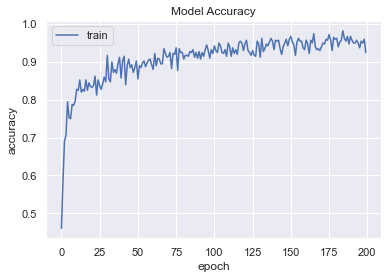

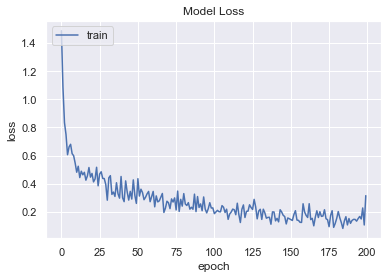

In [13]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [14]:
##########################
# # view model summary # #
##########################
model.model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 1, 128)            81920     
                                                                 
 dropout_30 (Dropout)        (None, 1, 128)            0         
                                                                 
 batch_normalization_30 (Bat  (None, 1, 128)           512       
 chNormalization)                                                
                                                                 
 lstm_31 (LSTM)              (None, 1, 128)            131584    
                                                                 
 dropout_31 (Dropout)        (None, 1, 128)            0         
                                                                 
 batch_normalization_31 (Bat  (None, 1, 128)           512       
 chNormalization)                                    

### MODEL TESTING
> * get model accuracy on the test dataset
> * generate confusion matrix
> * generate ROC curves
> * save the model if appropriate

In [15]:
y_pred = model.predict_proba(X_test)

# evaluate predictions
acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 95.000%


##### Confusion Matrix

<AxesSubplot:>

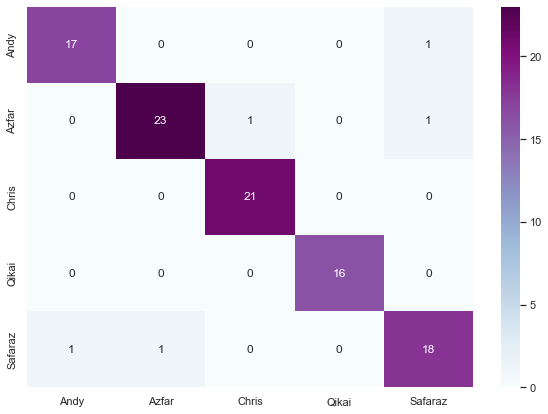

In [16]:
# confusion matrix
cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                     columns = [i for i in np.unique(lb.inverse_transform(y_test))])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

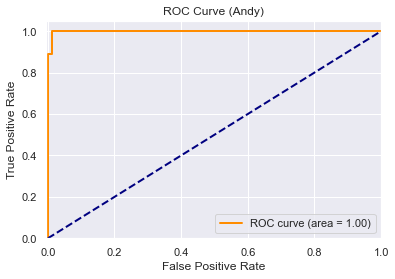

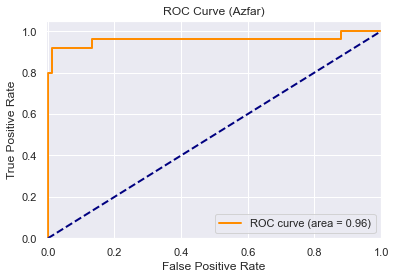

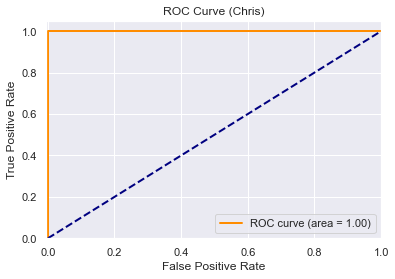

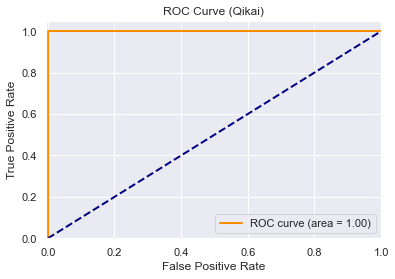

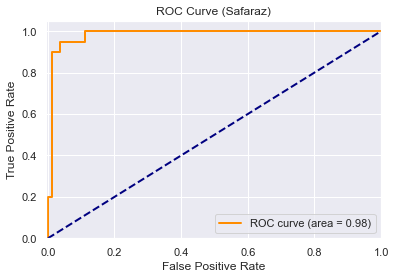

In [17]:
# compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    lw = 2
    plt.plot(
        fpr[i],
        tpr[i],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[i],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Combined Plot)

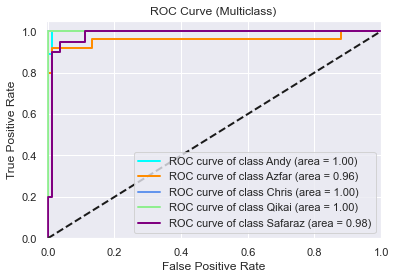

In [18]:
# compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# first aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
# plt.figure()
# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

# plt.plot(
#     fpr["macro"],
#     tpr["macro"],
#     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
#     color="navy",
#     linestyle=":",
#     linewidth=4,
# )

colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend(loc="lower right")
plt.show()

##### ROC Curve (Average out)

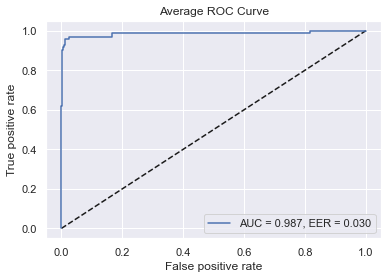

In [19]:
fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

# calculate equal-error-rate
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Average ROC Curve')
plt.legend(loc='best')
plt.show()

### FIT AND SAVE MODEL
> * fitting of model
> * get accuracy and loss of model
> * saving model

In [20]:
##############################################
# # normalisation and reshaping of dataset # #
##############################################
# loading of dataset
df = pd.read_csv(DATASET_LINK)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
X = dataset[:,3:].astype(float)
Y = dataset[:,0]

# convert target Y to labelbinarizer Y for model
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

# # normalisation to 0 to 1
# scaler = MinMaxScaler(feature_range=(0, 1))
# X = scaler.fit_transform(X)


# reshaping the dataset to include LSTM Timesteps
X = np.asarray(X, dtype=np.float32)
X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

Epoch 1/200
100/100 [==============================] - 3s 3ms/step - loss: 1.4009 - accuracy: 0.4700
Epoch 2/200
100/100 [==============================] - 0s 3ms/step - loss: 0.9800 - accuracy: 0.6400
Epoch 3/200
100/100 [==============================] - 0s 3ms/step - loss: 0.8309 - accuracy: 0.6840
Epoch 4/200
100/100 [==============================] - 0s 3ms/step - loss: 0.7883 - accuracy: 0.7020
Epoch 5/200
100/100 [==============================] - 0s 3ms/step - loss: 0.7749 - accuracy: 0.7180
Epoch 6/200
100/100 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.7520
Epoch 7/200
100/100 [==============================] - 0s 3ms/step - loss: 0.7096 - accuracy: 0.7440
Epoch 8/200
100/100 [==============================] - 0s 3ms/step - loss: 0.7161 - accuracy: 0.7360
Epoch 9/200
100/100 [==============================] - 0s 3ms/step - loss: 0.5649 - accuracy: 0.8000
Epoch 10/200
100/100 [==============================] - 0s 3ms/step - loss: 0.5442 - accura

100/100 [==============================] - 0s 3ms/step - loss: 0.2323 - accuracy: 0.9120
Epoch 82/200
100/100 [==============================] - 0s 3ms/step - loss: 0.2633 - accuracy: 0.9080
Epoch 83/200
100/100 [==============================] - 0s 3ms/step - loss: 0.2537 - accuracy: 0.9360
Epoch 84/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1848 - accuracy: 0.9380
Epoch 85/200
100/100 [==============================] - 0s 3ms/step - loss: 0.2257 - accuracy: 0.9220
Epoch 86/200
100/100 [==============================] - 0s 3ms/step - loss: 0.2855 - accuracy: 0.9080
Epoch 87/200
100/100 [==============================] - 0s 3ms/step - loss: 0.2806 - accuracy: 0.9240
Epoch 88/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1737 - accuracy: 0.9440
Epoch 89/200
100/100 [==============================] - 0s 3ms/step - loss: 0.2214 - accuracy: 0.9320
Epoch 90/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1881 - accuracy: 

100/100 [==============================] - 0s 3ms/step - loss: 0.2132 - accuracy: 0.9380
Epoch 161/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1949 - accuracy: 0.9420
Epoch 162/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1696 - accuracy: 0.9500
Epoch 163/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1313 - accuracy: 0.9520
Epoch 164/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1048 - accuracy: 0.9520
Epoch 165/200
100/100 [==============================] - 0s 3ms/step - loss: 0.2189 - accuracy: 0.9460
Epoch 166/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1367 - accuracy: 0.9600
Epoch 167/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1799 - accuracy: 0.9380
Epoch 168/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1771 - accuracy: 0.9480
Epoch 169/200
100/100 [==============================] - 0s 3ms/step - loss: 0.1702 - a

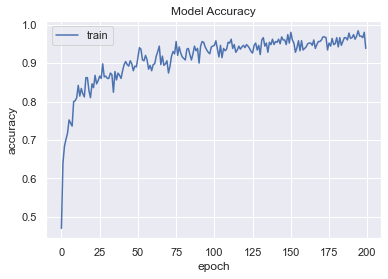

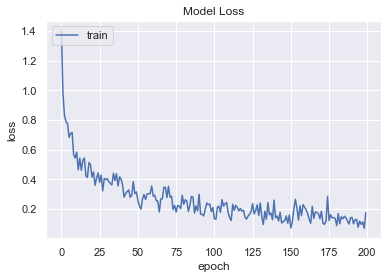

In [21]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### SAVE MODEL

In [22]:
##################
# # save model # #
##################

model.model.save("model/key_classifier.h5")

###########################
# # save model in colab # #
###########################

# model.model.save(F"/content/gdrive/My Drive/Colab Notebooks/overall_key_classifier.h5")

### LOAD MODEL

In [23]:
# ##################
# # # load model # #
# ##################

# model = create_model()
model = load_model("model/key_classifier.h5")

# ###########################
# # # load model in colab # #
# ###########################

# # model.model = load_model("/content/gdrive/My Drive/Colab Notebooks/overall_key_classifier.h5")

### LIVE TESTING
> * import any new data to perform testing and prediction

In [24]:
# import unseen data
pred_df = pd.read_csv(TEST_DATA_LINK)
pred_df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,Andy,1,1,0.174239,0.409866,0.235627,0.133840,0.171659,0.037820,0.156984,...,0.137544,0.091721,-0.045824,0.099726,0.099142,-0.000585,0.120912,0.135934,0.015022,0.163508
1,Andy,1,2,0.145289,0.154851,0.009562,0.131217,0.129134,-0.002083,0.130980,...,0.164865,0.111584,-0.053281,0.101935,0.023678,-0.078258,0.140863,0.192325,0.051462,0.156958
2,Andy,1,3,0.122266,0.136321,0.014055,0.114905,0.125308,0.010402,0.144332,...,0.145501,0.095982,-0.049520,0.121049,0.091486,-0.029563,0.111422,0.145751,0.034329,0.169304
3,Andy,1,4,0.121075,0.132562,0.011487,0.134813,0.132049,-0.002763,0.135681,...,0.135072,0.089715,-0.045356,0.117885,0.089209,-0.028676,0.098095,0.139069,0.040974,0.168298
4,Andy,1,5,0.141361,0.124721,-0.016640,0.098268,0.149003,0.050735,0.128713,...,0.121480,0.078897,-0.042583,0.108607,0.049435,-0.059172,0.131348,0.156398,0.025050,0.170112


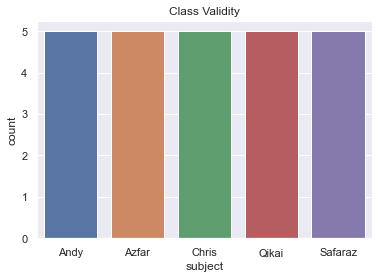

In [25]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [26]:
pred_dataset = pred_df.values

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[:,3:]

############################
# # predict a single row # #
############################

pred_row=pred_df.iloc[11:12,3:]

################################
# # normalise and shape data # #
################################
pred_row = pred_row.values.tolist()
# pred_row = scaler.transform(pred_row)
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

Y = ['Andy', 'Azfar', 'Chris', 'Qikai', 'Safaraz']
Y = np.asarray(Y)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

In [27]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)
pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

pred_results = np.column_stack((pred, acc))

df = pd.DataFrame(data=pred_results, index=None, columns=['Prediction', 'Accuracy'])
print(df)

  Prediction   Accuracy
0      Chris  0.9985672
